In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from engine.model import PIC
import yaml
from easydict import EasyDict as edict
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from engine.utils import read_config
cfg = read_config('configs/config_noise_reduction.yaml')

# Mean Std

In [3]:
import engine.datasets as ed
if cfg.DATASET == 'ImageNet_noise_reduction':
    dataloader = ed.ImageNet_noise_reduction(cfg)
print(len(dataloader))

7800


In [4]:
mean, std = dataloader.calculate_mean_std()

Calculating mean ...


100%|██████████| 7800/7800 [00:16<00:00, 484.11it/s]


Calculating std ...


100%|██████████| 7800/7800 [00:15<00:00, 490.55it/s]


In [6]:
print('Mean = ', mean)
print('Std = ', std)

Mean =  [101.55896051 113.71319883 110.19717502]
Std =  [69.94532284 63.66328663 72.32120695]


# Deblure

In [3]:
from engine.utils import read_config
cfg = read_config('configs/config_deblure.yaml')

In [4]:
import engine.datasets as ed
if cfg.DATASET == 'GoPro_deblure':
    dataloader = ed.GoPro_deblure(cfg)
print(len(dataloader))

728


In [5]:
mean, std = dataloader.calculate_mean_std()

Calculating mean ...


100%|██████████| 728/728 [00:13<00:00, 52.03it/s]


Calculating std ...


100%|██████████| 728/728 [00:14<00:00, 51.82it/s]


In [6]:
print('Mean = ', mean)
print('Std = ', std)

Mean =  [111.95842572 113.79689066 118.01127043]
Std =  [59.39720184 56.73789445 56.79359916]


# Image Sample

<class 'numpy.ndarray'>
<class 'float'>


In [5]:
data_dict = dataloader[25]

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(data_dict['original_im'], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Изображение с шумом")
plt.imshow(data_dict['noisy_im'], cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [60]:
import numpy as np

discr = 100

def get_ind(x1, y1, x2, y2):
    if np.isclose(x1, x2):
        return None
    k = (y1 - y2) / (x1 - x2)
    if np.abs(k) > 1:
        return None
    ind = int((k + 1) / 2 * (discr - 1))
    return ind
    

def RHT(points):
    rht = np.zeros(discr)
    for _ in range(1000):
        random_indices = np.random.choice(points.shape[0], 2, replace=False)
        x1, y1 = points[random_indices[0], :2]
        x2, y2 = points[random_indices[1], :2]
        ind = get_ind(x1, y1, x2, y2)
        if ind is not None:
            rht[ind] += 1
    return rht


points = np.array([[1, 2, 3],
                [3, 2, 2],
                [2, 3, 8]])
a, b = points[1, :2]
RHT(points)

array([345.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0., 314.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
       341.])

In [24]:
import numpy as np
points = np.array([[1, 2, 3],
                    [4, 2, 2],
                    [2., 2, 8]])
points_list = [p.tolist() for p in points]
type(points_list[0][0])

float

In [1]:
import numpy as np
import cv2
from scipy.signal import convolve2d
from scipy.fft import fft2, ifft2


def wiener_filter(image, psf, K):
    """Применяет фильтр Винера к изображению.

    Args:
        image: Изображение (NumPy array).
        psf: Функция размытия (PSF) (NumPy array).
        K: Константа для аппроксимации отношения мощности шума к мощности сигнала.

    Returns:
        Восстановленное изображение (NumPy array).
    """
    image_fft = fft2(image)
    psf_fft = fft2(psf, s=image.shape)
    psf_fft_conj = np.conj(psf_fft)

    # Фильтр Винера в частотной области
    wiener_filter_freq = psf_fft_conj / (np.abs(psf_fft)**2 + K)

    # Восстановленное изображение в частотной области
    filtered_fft = image_fft * wiener_filter_freq
    # Обратное преобразование Фурье
    filtered = np.real(ifft2(filtered_fft))

    return filtered


def generate_gaussian_psf(size, sigma):
    """Генерирует 2D-гауссову функцию размытия (PSF).

    Args:
        size: Размер PSF (кортеж (rows, cols)).
        sigma: Стандартное отклонение Гаусса.

    Returns:
        PSF (NumPy array).
    """
    rows, cols = size
    center_row, center_col = rows // 2, cols // 2
    x, y = np.indices((rows, cols), dtype=np.float64)
    x -= center_col
    y -= center_row
    psf = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    psf /= np.sum(psf) # Нормализуем
    return psf

# Пример использования
image_path = '../data/ImageNet/Train/Data/n07716906/n07716906_17.JPEG'  # Замените на путь к вашему изображению
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if img is not None:
    # Параметры
    psf_size = (15, 15)  # Размер PSF
    sigma = 2.0 # Стандартное отклонение Гаусса
    K = 0.01  # Константа для фильтра Винера

    # Генерация PSF
    psf = generate_gaussian_psf(psf_size, sigma)

    # Имитация размытия и добавления шума
    blurred_img = convolve2d(img, psf, mode='same', boundary='fill', fillvalue=0)
    noise = np.random.normal(0, 10, blurred_img.shape)
    noisy_blurred_img = np.clip(blurred_img + noise, 0, 255).astype(np.uint8)

    # Применение фильтра Винера
    restored_img = wiener_filter(noisy_blurred_img, psf, K)

    # Приводим к типу uint8 для вывода
    restored_img = np.clip(restored_img, 0, 255).astype(np.uint8)

    # Визуализация
    cv2.imshow("Original Image", img)
    cv2.imshow("Noisy Blurred Image", noisy_blurred_img)
    cv2.imshow("Restored Image", restored_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    cv2.imwrite("restored_image.jpg", restored_img) # Сохраняем результат
else:
    print("Ошибка при загрузке изображения.")

In [15]:
import aspose.pycore as aspycore
from aspose.imaging import Image, RasterImage
from aspose.imaging.imagefilters.filteroptions import GaussWienerFilterOptions
import os

if 'TEMPLATE_DIR' in os.environ:
	templates_folder = os.environ['TEMPLATE_DIR']
else:
	templates_folder = r"C:\Users\USER\Downloads\templates"

delete_output = 'SAVE_OUTPUT' not in os.environ
data_dir = templates_folder
# Загрузите изображение
with Image.load(dataloader.im_list[0]) as image:
	# Вставьте изображение в RasterImage
	if aspycore.is_assignable(image, RasterImage):
		raster_image = aspycore.as_of(image, RasterImage)
		# Создайте экземпляр класса GaussWienerFilterOptions и установите размер радиуса и значение сглаживания.
		options = GaussWienerFilterOptions(12, 3)
		options.grayscale = False
		# Примените фильтр MedianFilterOptions к объекту RasterImage и сохраните полученное изображение.
		raster_image.filter(image.bounds, options)
		image.save("result.jpg")


# from GPT

[[0.83416796 0.6927962  0.73718793 ... 0.4140883  0.83576165 0.89892052]
 [0.84948566 0.72640973 0.72289544 ... 0.84570237 0.75075078 0.73604494]
 [0.8721838  0.82230587 0.8495855  ... 0.7359856  0.91260211 0.84272197]
 ...
 [0.02923904 0.15357065 0.20412437 ... 0.41693542 0.62589244 0.545196  ]
 [0.16080581 0.04355663 0.20687862 ... 0.57314212 0.72797693 0.52041974]
 [0.01624676 0.17697439 0.10301456 ... 0.53253744 0.60648668 0.6242423 ]]


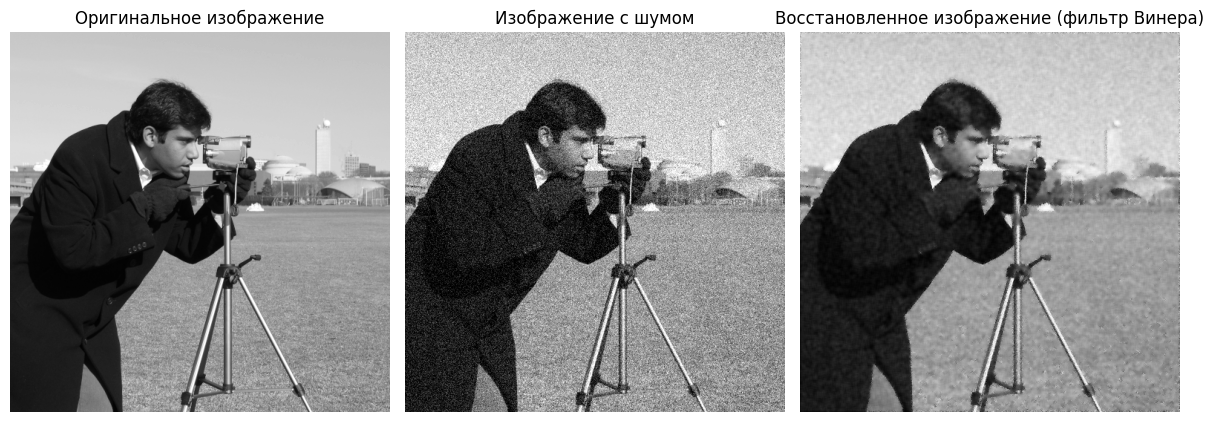

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import wiener
from skimage.util import random_noise
from skimage import data

# Загрузка исходного изображения
original_image = data.camera()

# Добавление гауссовского шума к изображению
noisy_image = random_noise(original_image, mode='gaussian', mean=0, var=0.01)

# Применение фильтра Винера
filtered_image = wiener(noisy_image, (5, 5))  # Размер окна фильтра: 5x5

# Визуализация результатов
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title("Оригинальное изображение")
plt.imshow(original_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Изображение с шумом")
plt.imshow(noisy_image, cmap='gray')
plt.axis('off')

print(noisy_image)

plt.subplot(1, 3, 3)
plt.title("Восстановленное изображение (фильтр Винера)")
plt.imshow(filtered_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def wiener_filter(noisy_signal, signal_psd, noise_psd, delta=1e-6):
  """Применяет фильтр Винера к зашумленному сигналу.

  Args:
      noisy_signal: Зашумленный сигнал (1D numpy array).
      signal_psd: Оценка спектральной плотности мощности сигнала (1D numpy array).
      noise_psd: Оценка спектральной плотности мощности шума (1D numpy array).
      delta: Параметр сглаживания.

  Returns:
      Отфильтрованный сигнал (1D numpy array).
  """
  wiener_filter_tf = signal_psd / (signal_psd + noise_psd + delta)
  
  # Переводим во временную область
  filtered_signal = np.fft.ifft(np.fft.fft(noisy_signal) * wiener_filter_tf)
  return np.real(filtered_signal)

# 1. Генерация тестового сигнала
signal_length = 1024
time = np.linspace(0, 1, signal_length, endpoint=False)
clean_signal = np.sin(2 * np.pi * 10 * time) + 0.5 * np.sin(2 * np.pi * 50 * time)

# 2. Добавление гауссовского шума
noise_std = 0.5  # Стандартное отклонение шума
noise = np.random.normal(0, noise_std, signal_length)
noisy_signal = clean_signal + noise

# 3. Оценка спектральных плотностей мощности (PSD)
# Используем метод Велча
nperseg = 256  # длина сегмента для оценки PSD
f, signal_psd = signal.welch(clean_signal, fs=signal_length, nperseg=nperseg)
_, noise_psd = signal.welch(noise, fs=signal_length, nperseg=nperseg)

# 4. Применение фильтра Винера
filtered_signal = wiener_filter(noisy_signal, signal_psd, noise_psd)


# 5. Визуализация результатов
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(time, clean_signal)
plt.title('Чистый сигнал')
plt.subplot(3, 1, 2)
plt.plot(time, noisy_signal)
plt.title('Зашумленный сигнал')
plt.subplot(3, 1, 3)
plt.plot(time, filtered_signal)
plt.title('Отфильтрованный сигнал (Винер)')
plt.tight_layout()
plt.show()

ValueError: operands could not be broadcast together with shapes (1024,) (129,) 

/home/petr/.local/lib/python3.10/site-packages/scipy/signal/_signaltools.py:1647: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
/home/petr/.local/lib/python3.10/site-packages/scipy/signal/_signaltools.py:1647: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
/tmp/ipykernel_38986/1682856786.py:12: RuntimeWarning: invalid value encountered in cast
  filtered_image[:, :, i] = wiener(image[:, :, i], (5, 5))


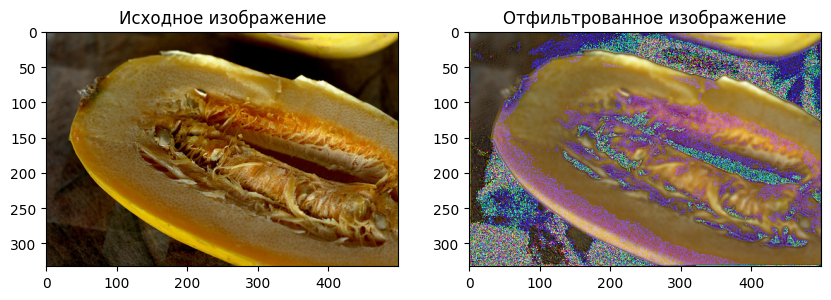

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import wiener
from skimage import io, color

# Загрузка цветного изображения
image = io.imread('../data/ImageNet/Train/Data/n07716906/n07716906_17.JPEG')


# Применение фильтра Винера к каждому каналу
filtered_image = np.zeros_like()
for i in range(3):  # 0: R, 1: G, 2: B
    filtered_image[:, :, i] = wiener(image[:, :, i], (5, 5))

# Отображение исходного и отфильтрованного изображений
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Исходное изображение')
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.title('Отфильтрованное изображение')
plt.imshow(filtered_image)

plt.show()